# k-means from scratch

In this walkthrough, we will learn how to implement the k-means clustering algorithm from scratch using Python.

#### Here are the dependencies & requirements for running the code in this notebook:
 - Python 3.6
 - `pandas`
 - `numpy`
 - `sklearn`
 - `matplotlib`
 - `seaborn`
 - `scipy`
 
#### Here is a high-level overview of what we'll cover tonight:
1. Introduction & Background
2. How do we train a k-means model?
3. How do we evaluate our model?
4. How does our "from-scratch" implementation compare to a standard ML library?

## 1. Introduction & Background
The k-means clustering algorithm is an unsupervised machine learning method that is useful for identifying similar groups in your dataset.

The $ k $ refers to the number of partitions (or clusters) we aim to separate our data into.

The $ means $ refers to the fact that each data point will belong a specific cluster with the nearest mean. Said differently, each of the clusters will have a mean that is calculated using the points belonging to that cluster. Individual points will be assigned to a specific cluster based upon the distance of the individual point to the cluster mean. Whichever distance is the smallest, the individual data point will be assigned to that cluster.

## 2. How do we train a k-means model?
The most common implementation uses an **iterative refinement technique** which means that we will *assign* each of our data points to a cluster with the nearest mean, and then *update* the mean of each cluster.

The mean of each cluster is what we call a **representative point** (or centroid). These centroids will change in each step of our iterative refinement technique, until the centroids no longer change (i.e., converge). A common approach for initializing the centroids is to just pick $ k $ points randomly.

OK, that sounds great. But I [still don't get it.](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)

*Why haven't you shown me any code yet?*

### Let's get some data
We'll be using the [infamous iris dataset](https://archive.ics.uci.edu/ml/datasets/iris) which is commonly used for testing out machine learning tasks. 

*Sidebar/Spoiler: The iris dataset is commonly used for classification - one of my goals of this walkthrough is to differentiate clustering from classification.*

It contains 150 records and four features, with 50 records belonging to each of the three classes.

In [98]:
import pandas as pd
import numpy as np
import os
import time
import math
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sil_coef import silhouette_coefficient
import random
random.seed(10)

warnings.filterwarnings("ignore")
sns.set(style="white", color_codes=True)
%matplotlib inline

def get_iris_data(file_name):
    """Simple function to pre-process the iris dataset."""

    # Specify column names and read in data
    i_names = ['s_len', 's_wid', 'p_len', 'p_wid', 'species']
    iris = pd.read_table(os.path.join(os.getcwd(), file_name), header=None, sep=',', names=i_names)

    return iris

In [99]:
df = get_iris_data('iris.data')
df.head()

,s_len,s_wid,p_len,p_wid,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [100]:
print("The data set contains {} records and {} features.".format(df.shape[0], df.shape[1]))

The data set contains 150 records and 5 features.


In [46]:
df['species'].value_counts()

Iris-virginica     50
Iris-setosa        50
Iris-versicolor    50
Name: species, dtype: int64

### Let's check out the distribution of two features among the three classes.

We can test out different feature combinations to see how the values are distributed based upon the classes.

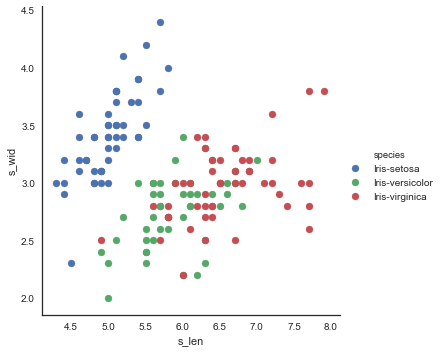

In [47]:
sns.FacetGrid(df, hue="species", size=5) \
   .map(plt.scatter, "s_len", "s_wid") \
   .add_legend()

We can also just look at one of the features to get a better sense of a feature's distribution.

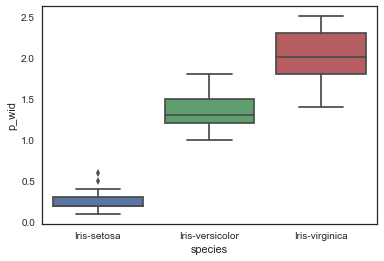

In [7]:
sns.boxplot(x="species", y="p_wid", data=df)

### Let's get down to business

Now we're *finally* going to implement our iterative refinement technique. 

At the highest level, here's the pseudocode to do so:

    Initialize centroids
    
    Enter loop
        
        Stash copy of old centroids
        Calculate distance from each data point to centroid
        Assign each data point to cluster with closest mean
        Calculate the new means of each cluster
        Update the centroids
        
    Continue until centroids converge
    
And the corresponding "code-code":

In [48]:
class KMeans:
    """The k-means algorithm."""

    def __init__(self, n_clusters):
        self.data = pd.DataFrame()
        self.n_clusters = n_clusters
        self.centroids = pd.DataFrame()
        self.clusters = np.ndarray(1)
        self.old_centroids = pd.DataFrame()
        self.verbose = False
        self.predictions = list()

    def train(self, df, verbose):
        self.verbose = verbose
        self.data = df.copy(deep=True)
        self.clusters = np.zeros(len(self.data))

        if 'species' in self.data.columns:
            self.data.drop('species', axis=1, inplace=True)

        # Randomly initialize centroids
        unique_rows = self.data.drop_duplicates()
        unique_rows.reset_index(drop=True, inplace=True)
        self.centroids = unique_rows.sample(n=self.n_clusters)
        self.centroids.reset_index(drop=True, inplace=True)

        if self.verbose:
            print("\nRandomly initiated centroids:")
            print(self.centroids)

        # Initialize old centroids as a matrix of all 0's
        self.old_centroids = pd.DataFrame(np.zeros(shape=(self.n_clusters, self.data.shape[1])),
                                          columns=self.data.columns)

        # Compare every data point in our dataset to each of the k-means and assign each point to closest cluster
        while not self.old_centroids.equals(self.centroids):
            
            if self.verbose:
                time.sleep(3)

            # Stash old centroids
            self.old_centroids = self.centroids.copy(deep=True)

            # Iterate through each data point in the matrix
            for row_i in range(0, len(self.data)):
                distances = list()
                point = self.data.iloc[row_i]

                # Calculate the distance between the current point and each of the centroids
                for row_c in range(0, len(self.centroids)):
                    centroid = self.centroids.iloc[row_c]
                    distances.append(np.linalg.norm(point - centroid))

                # Assign this data point to a cluster
                self.clusters[row_i] = np.argmin(distances)

            # For each cluster extract the values which now belong to each cluster and calculate new k-means
            for cls in range(0, self.n_clusters):

                cls_idx = np.where(self.clusters == cls)[0]

                if len(cls_idx) == 0:
                    self.centroids.loc[cls] = self.old_centroids.loc[cls]
                else:
                    # Set the new k-mean to the mean value of the data points within this cluster
                    self.centroids.loc[cls] = self.data.iloc[cls_idx].mean()
                    
                if self.verbose:
                    print("\nRow indices belonging to cluster {}: [n={}]".format(cls, len(cls_idx)))
                    print(cls_idx)

            if self.verbose:
                print("\nOld centroids:")
                print(self.old_centroids)
                print("New centroids:")
                print(self.centroids)

In [102]:
# Run through a simple application
number_of_clusters = 3
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.train(df=df, verbose=False)

In [103]:
# Extract the results
df['cluster'] = kmeans.clusters
centroids = kmeans.centroids
centroids['cluster'] = 'centroid'
all_df = pd.concat([df, centroids])

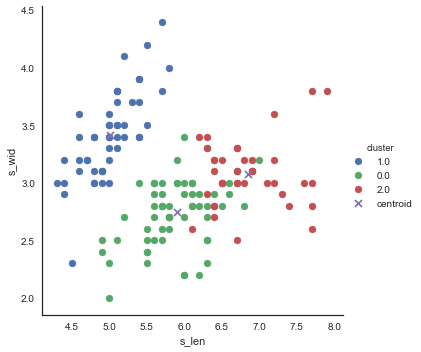

In [39]:
# Plot the cluster centroids
sns.FacetGrid(all_df, hue="cluster", size=5, hue_kws={"marker":["o", "o", "o", "x"]}).map(plt.scatter, "s_len", "s_wid").add_legend()

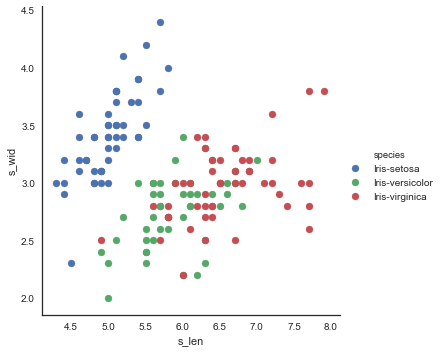

In [12]:
# Plot the clusters
sns.FacetGrid(all_df, hue="species", size=5).map(plt.scatter, "s_len", "s_wid").add_legend()

## 3. How do we evaluate our model?
So we've implemented our algorithm - now what do we do with it?

How do we know that picking $ k = 2 $ is better than $ k = 5 $? How can we back that up with some proof?

We'll apply two evaluation methods called the **Elbow method** and the **Silhouette method** to help us decide.

Because we're working with an unsupervised method, evaluating can be fairly subjective. We have no "ground-truth" to compare to - so we can't exactly define how accurate our clustering results are. However, we can represent how similar data points are within the same cluster and how dissimilar data points are in different clusters. In other words, how well-separated is our data with respect to each cluster centroid?

The Elbow method calculates **distortion**, or the average minimum distance from each data point to a centroid. In other words, we go through each data point and record the distance between the data point and the closest centroid. Then, we average all these minimum distances. This gives us a sense of, on average, how close our data points are to a centroid.

The Silhouette method adds a little more flavor. We calculate the **silhouette** for each data point, which tells us how closely it is matched to data within its cluster and how loosely it is matched to data in the nearest cluster. We then average the silhouette for each of our data points. An average silhouette closer to 1 implies data points are in the appropriate cluster, while a silhouette close to -1 implies data points are in the wrong cluster.

For k=1	Avg. Sil. Coef: -1.0	Distortion: 1.9430341590370253
For k=2	Avg. Sil. Coef: 0.6936772807489379	Distortion: 0.8560279682448627
For k=3	Avg. Sil. Coef: 0.6849364629960379	Distortion: 0.6488394948953339
For k=4	Avg. Sil. Coef: 0.6446900682305832	Distortion: 0.5600996630989206
For k=5	Avg. Sil. Coef: 0.6270023226419248	Distortion: 0.5158151330424038


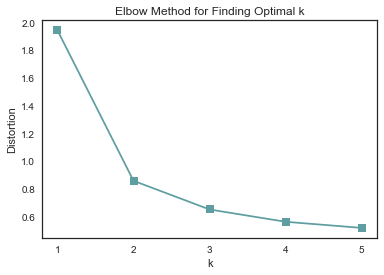

In [106]:
# Set up parameters
sil_coefs = list()
distortions = list()
K = [1, 2, 3, 4, 5]

# Test out multiple values for k
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.train(df=df, verbose=False)
    
    # Extract the results
    df['cluster'] = kmeans.clusters

    # Calculate silhouette coefficient
    s_c = silhouette_coefficient(df=df, clusters=kmeans.clusters, n_clusters=k)
    
    # Calculate distortion
    centroid_vals = kmeans.centroids[kmeans.centroids.columns[:-1]]
    d = df[df.columns[:-2]]
    distortion = sum(np.min(cdist(d, centroid_vals, 'euclidean'), axis=1)) / d.shape[0]
    
    print("For k={}\tAvg. Sil. Coef: {}\tDistortion: {}".format(k, s_c, distortion))
       
    # Keep track of cluster size metrics
    distortions.append(distortion)
    sil_coefs.append(s_c)
    
# Elbow plot
plt.plot(K, distortions, 's-', markersize=8, color='cadetblue', mec='gray')
plt.xlabel('k')
plt.xticks(K)
plt.ylabel('Distortion')
plt.title('Elbow Method for Finding Optimal k')
plt.show()

## 4. How does our "from-scratch" implementation compare to a standard ML library?

We'll benchmark our from-scratch implementation against the KMeans included in the scikit-learn.

In [111]:
from sklearn.cluster import KMeans as sklKMeans
from sklearn import datasets

k = 2

# Re-load data set
iris = get_iris_data('iris.data')
kmeans = sklKMeans(n_clusters=k, init='random').fit(iris[iris.columns[:-1]].values)

# Calculate silhouette coefficient
s_c = silhouette_coefficient(df=iris, clusters=kmeans.labels_, n_clusters=k)

# Calculate distortion
distortion = sum(np.min(cdist(iris[iris.columns[:-1]], kmeans.cluster_centers_, 'euclidean'), axis=1)) / iris.shape[0]
print("For k={}\tAvg. Sil. Coef: {}\tDistortion: {}".format(k, s_c, distortion))

For k=2	Avg. Sil. Coef: 0.6808136202936815	Distortion: 0.8560279682448629


### So, how'd we do?

The average silhouette coefficient is off by just a smidge and the distortion is pretty spot-on. Not too shabby!

# Conclusion

Tonight, we learned how to implement and evaluate the output of the unsupervised learning k-means algorithm (from scratch) using Python.

##### Questions or comments encouraged!

Thanks everyone

-Steve